<a href="https://colab.research.google.com/github/StanleyLiangYork/2023_journal_club_CNN4N/blob/main/Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This demo shows an example of training an conditional gan on the fashion mnist dataset

In [75]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate

Define the discriminator using embeding to encode the image label

In [2]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label) # use 50-dim embedding
  # scale up the embedding dimension to image dimensions with linear activation so that we can concatenate them later
  n_nodes = in_shape[0] * in_shape[1] # 28*28
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
  # image input
  in_image = Input(shape=in_shape)
  # concat label as an extra channel
  merge = Concatenate()([in_image, li]) # 28*28*4
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) # 14*14*128
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) # 7*7*128
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation='sigmoid')(fe)
  # define model
  model = Model([in_image, in_label], out_layer)
  # compile model
  opt = Adam(lr=2e-4, beta_1=0.5) # don't use default beta_1=0.99
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

define the generator

In [3]:
def define_generator(latent_dim, n_classes=10):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label) # use 50-dim embedding
  # scale the embedding to match the input dimension
  n_nodes = 7 * 7
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((7, 7, 1))(li)
  # image generator input
  in_latent = Input(shape=(latent_dim,))
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_latent)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, li])
  # upsample to 14x14
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 28x28
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # define model
  model = Model([in_latent, in_label], out_layer)
  return model


define the combined generator and discriminator model, for updating the generator

In [4]:
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # get noise and label inputs from generator model
  (gen_noise, gen_label) = g_model.input # concatenate latent noise and encoded label as input of the generator
  # get image output from the generator model
  gen_output = g_model.output # the generated images
  # connect image output and label input from generator as inputs to discriminator
  gan_output = d_model([gen_output, gen_label])
  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_noise, gen_label], gan_output)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [5]:
# load fashion mnist images
def load_real_samples():
 # load dataset
 (trainX, trainy), (_, _) = load_data()
 # expand to 3d, e.g. add channels
 X = expand_dims(trainX, axis=-1)
 # convert from ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [-1,1]
 X = (X - 127.5) / 127.5 # scale to (-1,1)
 return [X, trainy]

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
 # split into images and labels
 images, labels = dataset
 # choose random instances
 ix = randint(0, images.shape[0], n_samples)
 # select images and labels
 X, labels = images[ix], labels[ix]
 # generate class labels
 y = ones((n_samples, 1))
 return [X, labels], y

In [55]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  labels = randint(0, n_classes, n_samples)
  return z_input, labels

In [56]:
# use the generator to generate n fake examples, with class labels

def generate_fake_samples(generator, latent_dim, n_samples):
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = zeros((n_samples, 1))
  return [images, labels_input], y

In [57]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
  # enumerate batches over the training set
     for j in range(bat_per_epo):
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
  g_model.save('cgan_generator.h5')

In [58]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 0s 3ms/step
>1, 1/234, d1=0.752, d2=0.704 g=0.688
4/4 [==============================] - 0s 3ms/step
>1, 2/234, d1=0.414, d2=0.791 g=0.629
4/4 [==============================] - 0s 2ms/step
>1, 3/234, d1=0.236, d2=1.081 g=0.594
4/4 [==============================] - 0s 3ms/step
>1, 4/234, d1=0.207, d2=1.009 g=0.910
4/4 [==============================] - 0s 3ms/step
>1, 5/234, d1=0.250, d2=0.441 g=1.726
4/4 [==============================] - 0s 3ms/step
>1, 6/234, d1=0.339, d2=0.182 g=2.499
4/4 [==============================] - 0s 2ms/step
>1, 7/234, d1=0.428, d2=0.122 g=2.563
4/4 [==============================] - 0s 3ms/step
>1, 8/234, d1=0.304, d2=0.117 g=2.597
4/4 [==============================] - 0s 2ms/step
>1, 9/234, d1=0.317, d2=0.126 g=2.608
4/4 [==============================] - 0s 3ms/step
>1, 10/234, d1=0.288, d2=0.131 g=2.612
4/4 [==============================] - 0s 2ms/step
>1, 11/234, d1=0.244, d2=0.127 g=2.730
4/4 [==============

>10, 234/234, d1=0.714, d2=0.674 g=0.862


In [73]:
z = generate_latent_points(100, 100)
'''
0: "T-shirt/Top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle Boot"
'''

idx = 3 # 0 to 9
label = np.ones((100, 1)) * idx
preds = g_model.predict([z, label])

4/4 [==============================] - 0s 3ms/step


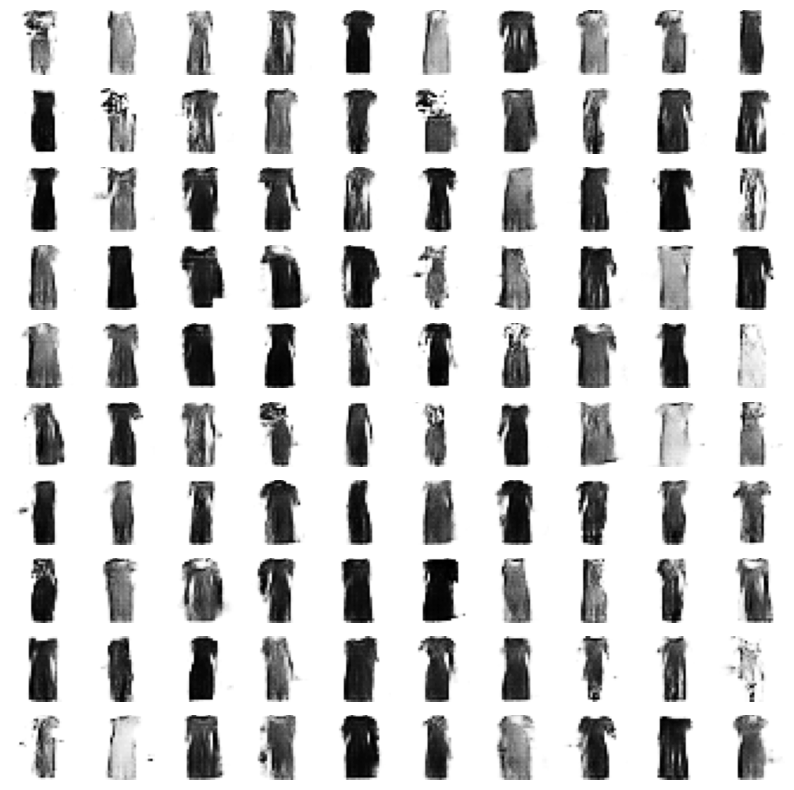

In [74]:
plt.figure(figsize=(10,10))
for i in range(100):
  plt.subplot(10, 10, i+1)
  plt.imshow(preds[i, :, :, 0], cmap='gray_r')
  plt.axis('off')
